In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [3]:
from stardist.models import StarDist2D
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [4]:
import os
import numpy as np
from tqdm.notebook import tqdm
from tifffile import imread, imwrite
from skimage.util import img_as_ubyte, img_as_uint
from skimage.measure import regionprops, regionprops_table, label
from skimage.segmentation import find_boundaries
from skimage.morphology import remove_small_objects

In [5]:
base_path = "Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/images/flamingo/output/"
output_path = "Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/images/flamingo/stardist_bw/"

positions = sorted([f.split('.')[0] for f in os.listdir(base_path) if "Position" in f])

In [ ]:
min_size = 200
max_size = 2000

for current_position in tqdm(positions[53:]):

    current_img = imread(os.path.join(base_path, f"{current_position}.tif"))
    current_bw_img = np.zeros(current_img.shape, dtype=np.uint8)
    current_bnd_img = np.zeros(current_img.shape, dtype=bool)

    for z in range(current_img.shape[0]):
        current_layer = current_img[z, :, :]
        current_labels, _ = model.predict_instances(normalize(current_layer), prob_thresh=0.6)
        current_areas = regionprops_table(current_labels, properties=["area"])

        if (current_areas['area'] < min_size).sum() > 0:
            current_labels = remove_small_objects(current_labels, min_size)
    
        if (current_areas['area'] > max_size).sum() > 0:
            current_labels_temp = remove_small_objects(current_labels, max_size)
            current_labels = current_labels - current_labels_temp
            
        current_bw = img_as_ubyte(current_labels > 0)
        current_bnd = find_boundaries(current_labels)
        current_bw_img[z, :, :] = current_bw
        current_bnd_img[z, :, :] = ~current_bnd

        current_final_bw = current_bw_img * current_bnd_img
        
        imwrite(os.path.join(output_path, f"{current_position}.tif"), current_final_bw)

  0%|          | 0/1471 [00:00<?, ?it/s]

3135820065.py (16): Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
3135820065.py (19): Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


In [102]:
min_size = 200
max_size = 2000
total_areas = []

for z in range(current_img.shape[0]):
# for z in range(1):
    current_layer = current_img[z, :, :]
    current_labels, _ = model.predict_instances(normalize(current_layer), prob_thresh=0.6)
    current_areas = regionprops_table(current_labels, properties=["area"])
    total_areas.append(current_areas['area'][:])
    
    if (current_areas['area'] < min_size).sum() > 0:
        current_labels = remove_small_objects(current_labels, min_size)

    if (current_areas['area'] > max_size).sum() > 0:
        current_labels_temp = remove_small_objects(current_labels, max_size)
        current_labels = current_labels - current_labels_temp
        
    current_bw = img_as_ubyte(current_labels > 0)
    current_bnd = find_boundaries(current_labels)
    current_bw_img[z, :, :] = current_bw
    current_bnd_img[z, :, :] = ~current_bnd

In [103]:
output_path = 'Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/images/flamingo/segmentation'

In [104]:
current_final_bw = current_bw_img * current_bnd_img
current_final_labels = label(current_final_bw)
current_final_labels = img_as_uint(current_final_labels)


imwrite(os.path.join(output_path, "bw.tif"), current_final_bw)
imwrite(os.path.join(output_path, "labels.tif"), current_final_labels)

dtype.py (500): Downcasting int64 to uint16 without scaling because max value 1170 fits in uint16


In [48]:
import seaborn as sns

_oldcore.py (1119): use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: ylabel='Count'>

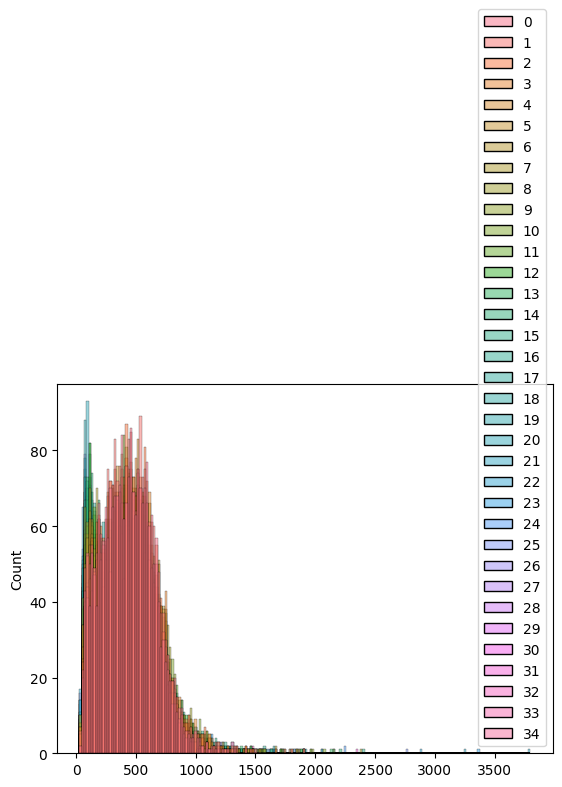

In [67]:
sns.histplot(total_areas)

(-0.5, 1495.5, 1495.5, -0.5)

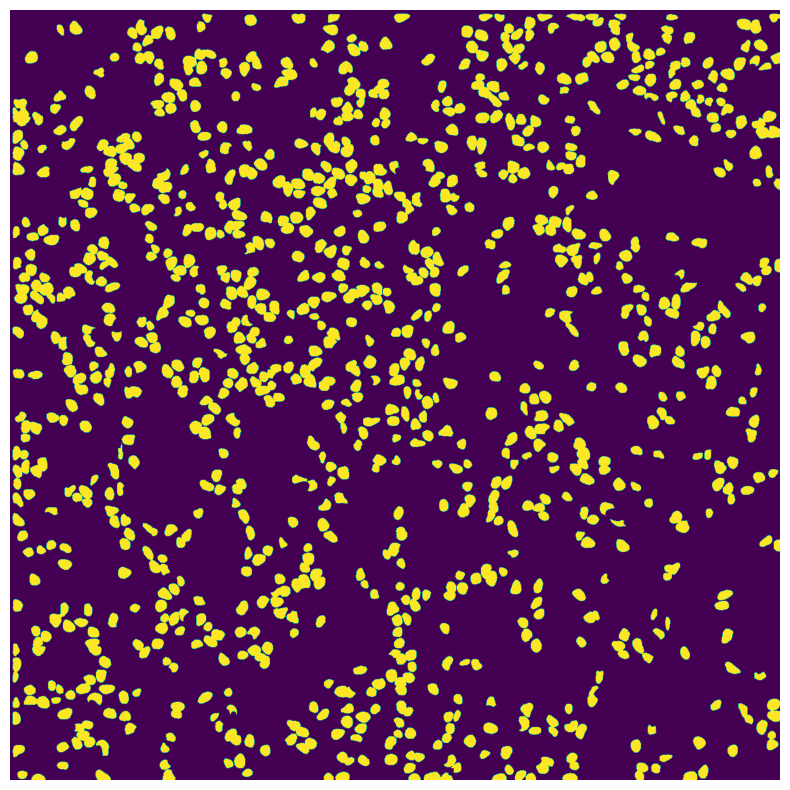

In [98]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(current_bw)
plt.axis("off")

(-0.5, 1495.5, 1495.5, -0.5)

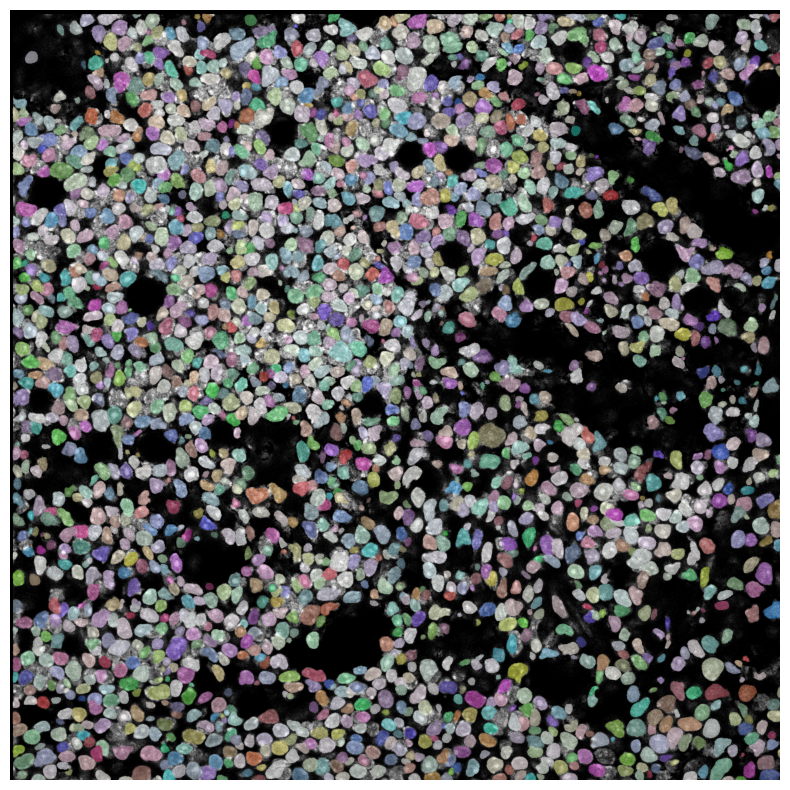

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(render_label(labels, img=current_img))
plt.axis("off")

In [11]:
for i in range(1, 1525):
    current_position = f"Position{i:03}.tif"
    if current_position not in os.listdir(base_path):
        print(current_position)

Position111.tif
